1. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
2. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).
3. __Use the__ `Validate` __button in the Assignments tab before submitting__.

__Include comments, derivations, explanations, graphs, etc.__ 

You __work in groups__ (= 3 people). __Write the full name and S/U-number of all team members!__

---

# Assignment 3 (Statistical Machine Learning 2024)
# **Deadline: 22 November 2024**

## Instructions
* Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` __including comments, derivations, explanations, graphs, etc.__ 
Elements and/or intermediate steps required to derive the answer have to be in the report. If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends.
* __Please use LaTeX to write down equations/derivations/other math__! How to do that in Markdown cells can be found [here](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/), a starting point for various symbols is [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).
* Please do __not add new cells__ to the notebook, try to write the answers only in the provided cells. Before you turn the assignment in, make sure everything runs as expected.
* __Use the variable names given in the exercises__, do not assign your own variable names. 
* __Only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.

For any problems or questions regarding the assignments, ask during the tutorial or send an email to charlotte.cambiervannooten@ru.nl and janneke.verbeek@ru.nl .

## Introduction
Assignment 3 consists of:
1. __The faulty lighthouse (30 points)__;
2. Gaussian processes (40 points);
3. Bayesian polynomial regression (30 points).

## Libraries

Please __avoid installing new packages__, unless really necessary.

In [42]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from mpl_toolkits.mplot3d import Axes3D

# Set fixed random seed for reproducibility
np.random.seed(2022)

## The faulty lighthouse (30 points)
A lighthouse is somewhere off a piece of straight coastline at a position $\alpha$ along the shore and a distance $\beta$ out to sea. Due to a technical fault, as it rotates the light source only occasionally and briefly flickers on and off. As a result it emits short, highly focused beams of light at random intervals. These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came. So far, $N$ flashes have been recorded at positions $\mathcal{D} = \{x_1,\ldots,x_N\}$. Where is the lighthouse?

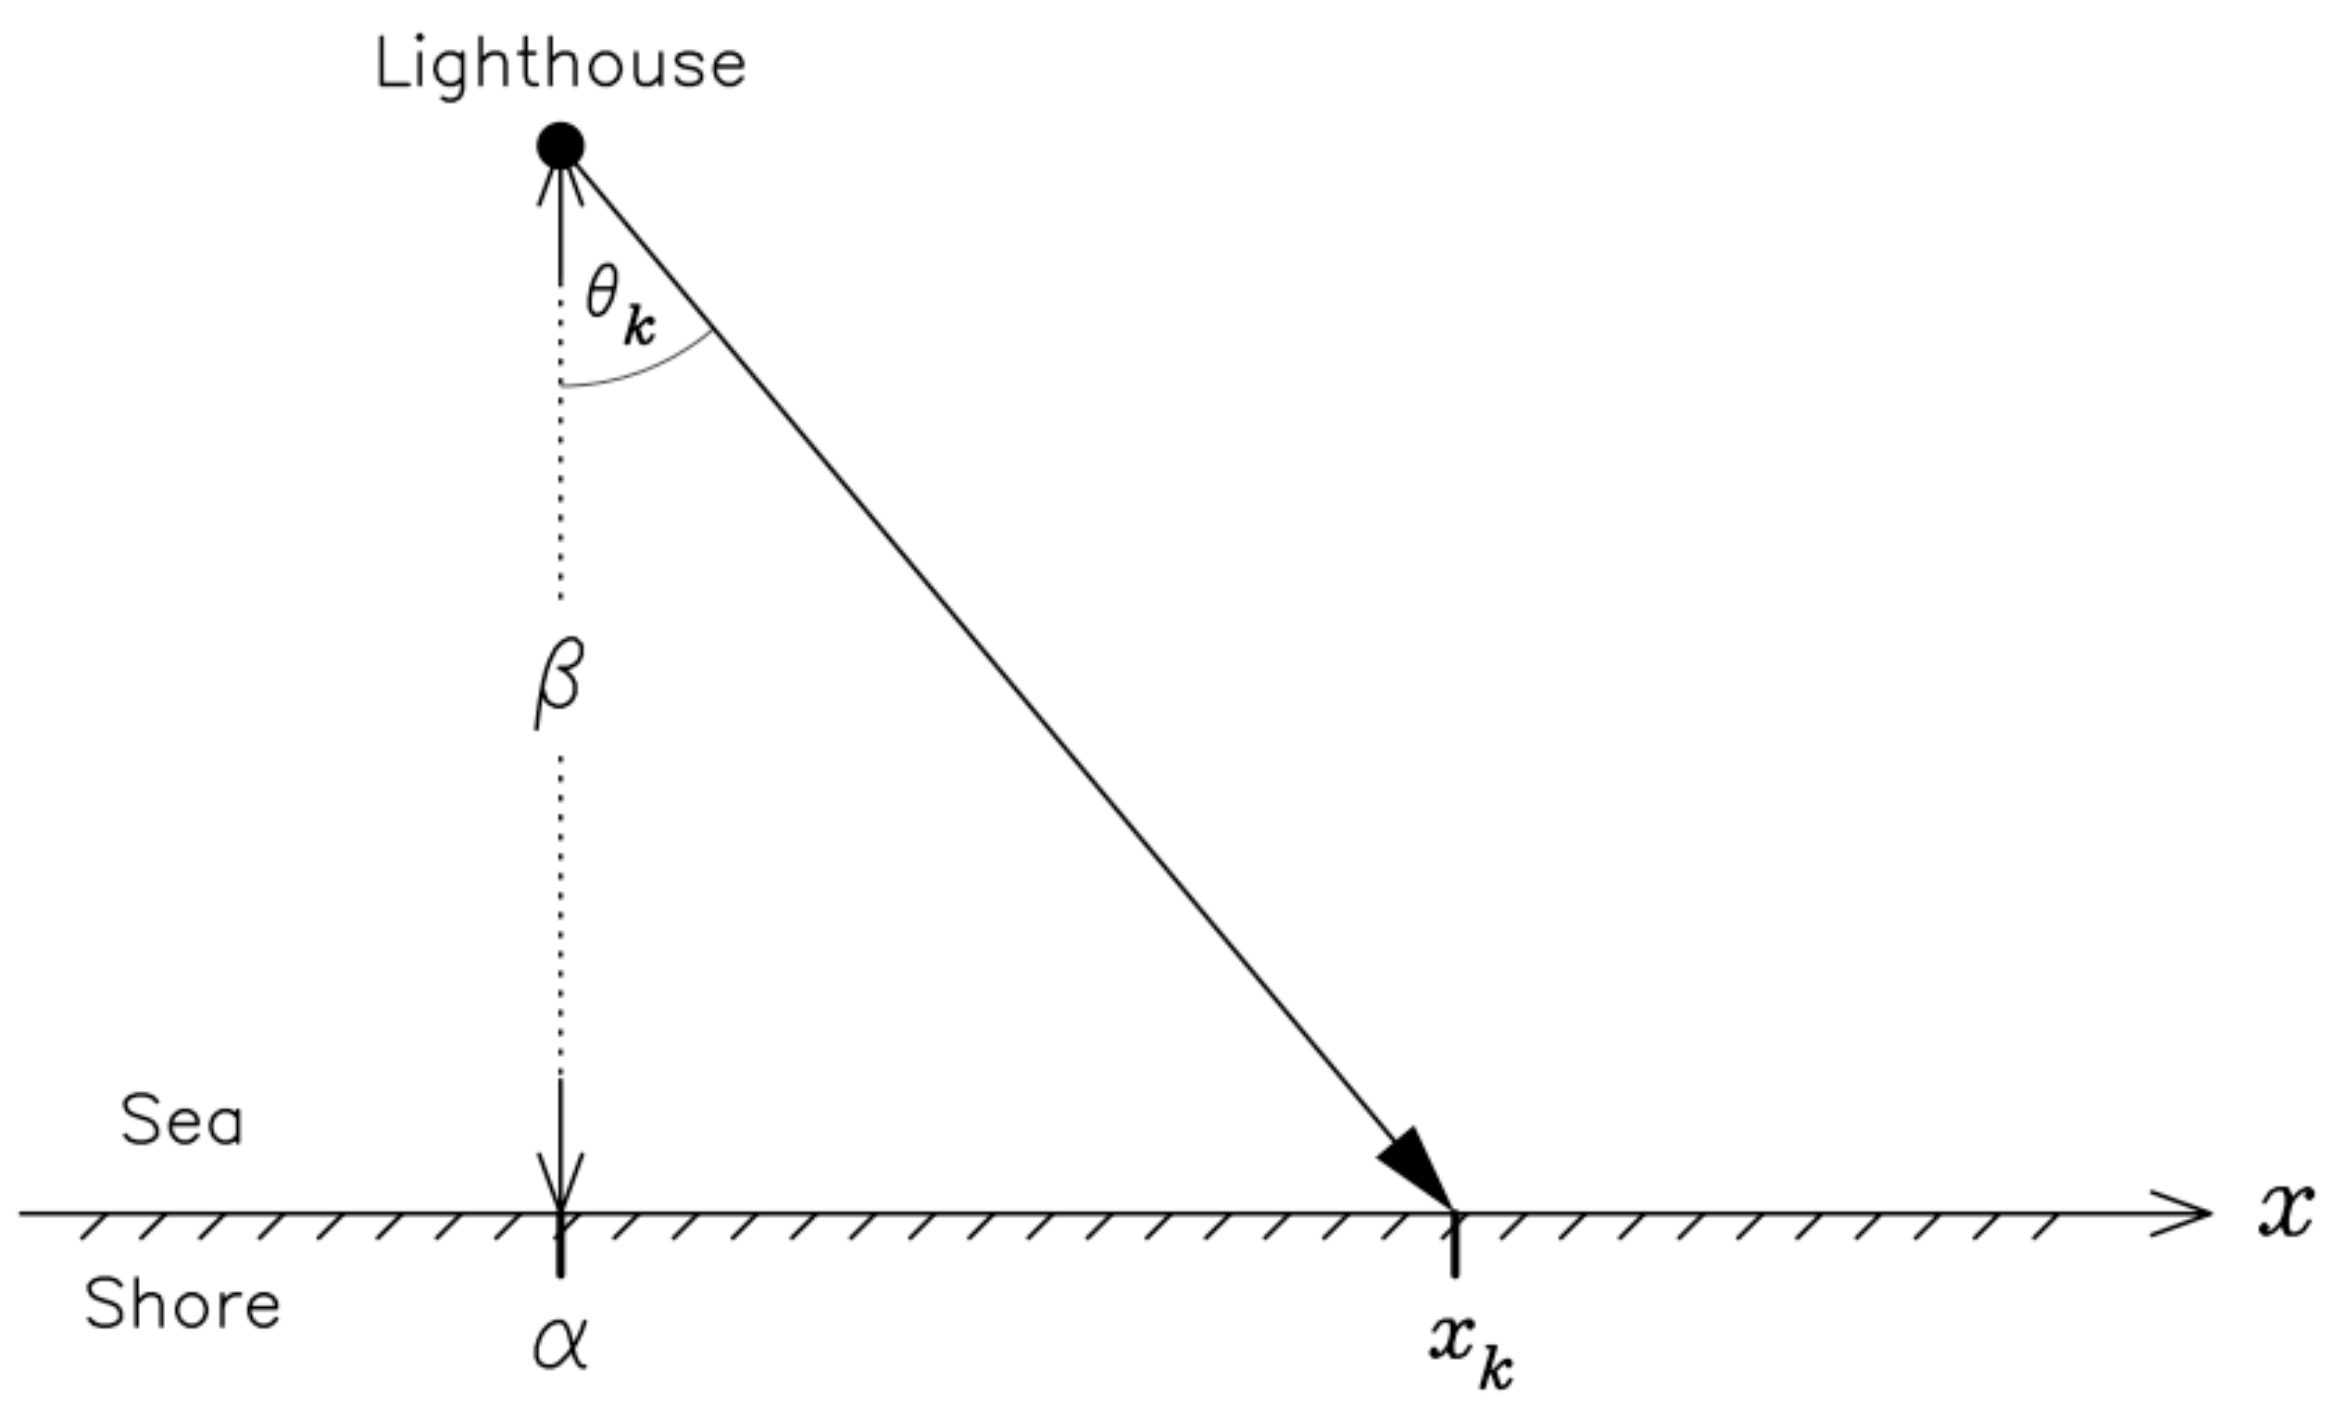

### Part 1: Constructing the model
1. Let $\theta_k$ be the (unknown) angle for the $k$-th recorded flash, see the figure above. Argue why
\begin{equation}
p(\theta_k|\alpha,\beta) = \frac{1}{\pi} \tag{1}
\end{equation}
would be a reasonable distribution over $\theta_k$ between $\pm \pi/2$ (zero otherwise).

**START ANSWER**

If the lighthouse was right on the shoreline and to the left of $x_k$ then $\theta_K = +\pi/2$. Conversely, it it was on the shoreline and to the right of $x_k$ then $\theta_k = -\pi/2$. Thus the full range of possible angles is $\theta_k \in [-\pi/2, +\pi/2]$. Since we have no reason to suspect it is at any particular angle, we can guess that all angles are equally likely which implies a uniform distribution. A uniform distribution is defined by 

$$
f(x) = 
\begin{cases}
\frac{1}{b-a} & \text{for } a \le x\le b, \\
0 & \text{for } x < a \text{ or } x > b
\end{cases}
$$

Where $a =-\pi/2, b=+\pi/2$ are the lower and upper bounds. Plugging our bounds into the equation we get the following distribution over $\theta_k$:

$$
p(\theta_k|\alpha, \beta) = 
\begin{cases}
\frac{1}{\pi} & \text{for } -\pi/2 \le \theta_k \le +\pi/2, \\
0 & \text{for } \theta_k < -\pi/2 \text{ or } \theta_k > +\pi/2
\end{cases}
$$

If $\theta_k$ were allowed to be outside of this range then that would imply the lighthouse was on land, which contradicts the claim that it is some (possibly zero) distance out to sea.

**END ANSWER**

We only have the position $x_k$ of the detector that recorded flash $k$, but we can relate this to the unknown $\theta_k$ via elementary geometry as
\begin{equation}
\beta \tan(\theta_k) = x_k - \alpha \tag{2}
\end{equation}

To get the probability distribution over $x_k$, we know from Bishop (page 18) that a change in variables for a probability distribution involves a "correction factor" by multiplying with the Jacobian of the transformation (similar to a change of variables for integration):

$$ p(x_k|\alpha, \beta) = \left|\frac{\text{d}\theta_k}{\text{d}x_k}\right| p(\theta_k|\alpha, \beta).$$

Since $\theta_k = \arctan\left(\frac{x_k - \alpha}{\beta}\right)$, we get (using the chain rule) the Jacobian term
\begin{equation}
\frac{\text{d}\theta_k}{\text{d}x_k} = \frac{1}{\beta \left[1 + \left(\frac{x_k-\alpha}{\beta}\right)^2 \right]},
\end{equation}
which after multiplication with $p(\theta_k|\alpha, \beta) = \frac{1}{\pi}$ gives the result
\begin{equation}
p(x_k|\alpha,\beta) = \frac{\beta}{\pi \left[\beta^2 + (x_k - \alpha)^2 \right]}. \tag{3}
\end{equation}

2. Plot the probability density  $p(x_k|\alpha,\beta)$ for $\beta = 2$ and $\alpha = 3$.

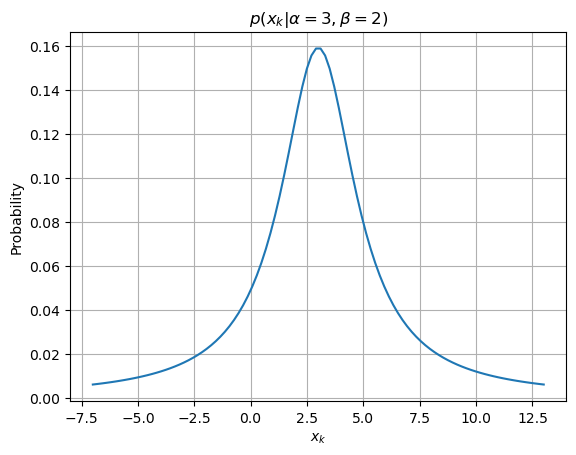

In [43]:
"""
Plot (prior) probability densities.
"""
# YOUR CODE HERE
def pdf(x, alpha, beta):
    return beta/(np.pi*(beta**2 + (x - alpha)**2))

alpha = 3
beta = 2
x = np.linspace(-10+alpha, 10+alpha, 100)
y = pdf(x, alpha, beta)

plt.plot(x, y)
plt.xlabel(r"$x_k$")
plt.ylabel("Probability")
plt.title(r"$p(x_k|\alpha=3, \beta=2)$");
plt.grid()

Inferring the position of the lighthouse corresponds to estimating $\alpha$ and $\beta$ from the data $\mathcal{D}$. This is still quite difficult, but if we assume that $\beta$ is known, then from Bayes' theorem we know that $p(\alpha | \mathcal{D},\beta) \propto p(\mathcal{D}|\alpha,\beta) \,p(\alpha | \beta)$. We have no a priori knowledge about the position $\alpha$ along the coast other than that it should not depend on the distance out at sea, so we take $p(\alpha | \beta) = p(\alpha) = constant$ over some large enough interval.

3. Show that with these assumptions the log of the posterior density can be written as
\begin{equation}
L = \ln\left(p(\alpha | \mathcal{D},\beta)\right) = constant - \sum_{k=1}^N \ln \left[ \beta^2 + (x_k - \alpha)^2 \right] \tag{4}
\end{equation}
and derive the constraint on $\alpha$ that the posterior maximum needs to satisfy. Note that the estimate $\hat{\alpha}$ that maximizes the posterior (MAP) does not have an explicit expression in general! Compare the MAP with the maximum likelihood (ML) estimate for $\alpha$. 

**START ANSWER**

The posterior density can be writtin as:

$$
p(\alpha | \mathcal{D}, \beta) \propto p(\mathcal{D}|\alpha\beta)p(\alpha|\beta)
$$

Then with the following steps we can transform it into the final equation above:

$$
\begin{align}
\ln(p(\alpha|\mathcal{D}, \beta)) &\propto \ln(p(\mathcal{D}|\alpha\beta)p(\alpha|\beta))\\

&\propto \ln\left(\prod_{k=1}^N \frac{\beta}{\pi[\beta^2+(x_k-\alpha)^2]}\times \text{constant})\right)\\

&\propto \ln(\text{constant}) + \sum_{k=1}^N\left(\ln(\beta/\pi)-\ln(\beta^2+(x_k-\alpha)^2)\right) \\

&\propto \text{constant} - \sum_{k=1}^N \ln([\beta^2+(x_k-\alpha)^2])



\end{align}
$$

Going from line 2 to line 3, we use the fact that a log of products is equal to a sum of logs. Additionally, going from line 3 to 4 we pull out the $\ln(\beta/\pi)$ into the constant factor.


To derive the constraint on  $\alpha$ we take the derivative of the posterior density with respect to $\alpha$ and we set it equal to 0. After taking the derivative of L WRT to $\alpha$ and setting equal to 0 we get the following constraint on $\alpha$:

$$

\frac{\partial \ln(p(\alpha|\mathcal{D}, \beta))}{\partial \alpha} = \sum_{k=1}^N \left(\frac{-2(x_k-\alpha)}{\beta^2+(x_k-\alpha)^2}\right) = 0\\
\sum_{k=1}^N \frac{x_k-\alpha}{\beta^2+(x_k-\alpha)^2}=0
$$

Additionally, because the prior $p(\alpha)$ is constant, the MAP and the MLE are equal. This is because the MAP is a function of the posterior, and MLE is a function of the likelihood. The posterior is proportional to the liklihood times the prior, thus when the prior is constant it has no effect during optimization, thus the MAP is proportional to the liklihood, which is the same as the MLE.

**END ANSWER**

Suppose we have a data set (in km) of $\mathcal{D} = \{ 3.6, 7.7, -2.6, 4.9, -2.3, 0.2, -7.3, 4.4, 7.3, -5.7 \}$. We also assume that the distance $\beta$ from the shore is known to be 2 km. As it is difficult to find a simple expression for the value of $\hat{\alpha}$ that maximizes $\ln\left(p(\alpha | \mathcal{D},\beta)\right)$, we try an alternative approach instead.

4. Create a function that returns the log-posterior and plot $p(\alpha | \mathcal{D},\beta = 2)$ as a function of $\alpha$ over the interval $[-10, 10]$. 

In [44]:
def log_posterior(alphas, beta, data):
    """
    Compute the log-posterior of alpha (given beta), which can take as input multiple alpha values.
    
    Parameters
    ----------
    alphas : array
        The array containing the possible positions of the lighthouse. Dim = A
    beta : numeric
        The distance from the shore. Scalar
    data : array
        The array of positions of the flashes recorded. Dim = N

    Returns
    -------
    array
        Log-posterior values. Dim = A
    """
    # log_posteriors = np.zeros_like(alphas)

    # for index, alpha in enumerate(alphas):
    #     log_posteriors[index] = -np.sum(np.log(beta**2 + (data - alpha)**2))

    # print(log_posteriors.shape)

    first_term = (data[:, np.newaxis] - alphas[np.newaxis, :])**2 # Dimension = N, A

    log_posteriors = -np.sum(np.log(beta**2 + first_term), axis = 0) # Dimension = A


    return log_posteriors.reshape(-1, 1) # Dimension A, 1

In [45]:
"""
Test for the log_posterior function.
"""
log_p = log_posterior(np.linspace(0, 1, 1), 0, np.array([1, 1, 1, 1, 1]))
print(log_p.shape)
print(np.array([[0]]).shape)
np.testing.assert_array_almost_equal(log_p, np.array([[0]]), decimal = 2)

(1, 1)
(1, 1)


Now plot $\log p(\alpha | \mathcal{D},\beta = 2)$ as a function of $\alpha$ over the interval $[-10, 10]$ with the help of `log_posterior`. 

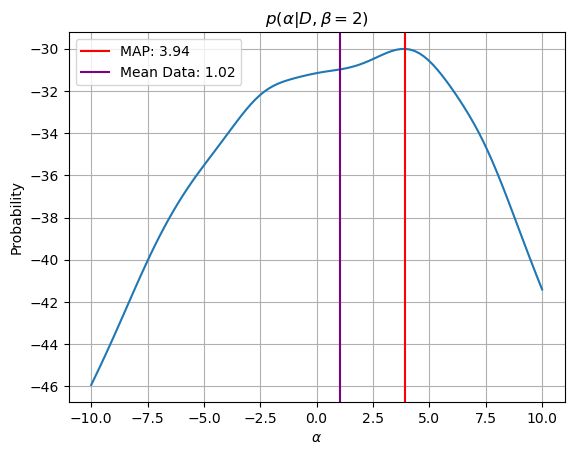

In [46]:
"""
Plot the log-posterior density.
"""

data = np.array([3.6, 7.7, -2.6, 4.9, -2.3, 0.2, -7.3, 4.4, 7.3, -5.7])
beta = 2
alphas = np.linspace(-10, 10, 100)
y = log_posterior(alphas, beta, data)
MAP = np.argmax(y)


plt.plot(alphas, y)
plt.xlabel(r"$\alpha$")
plt.ylabel("Probability")
plt.title(r"$p(\alpha|D,\beta=2)$");
plt.axvline(alphas[MAP], label=f"MAP: {alphas[MAP]:.2f}", color = "red")
plt.axvline(np.mean(data), label=f"Mean Data: {np.mean(data):.2f}", color = "purple")
plt.legend()
plt.grid()

Compare the MAP estimate (the $\alpha$ value where the (log-)posterior curve reaches its maximum) to the mean estimate of the dataset.

**START ANSWER (DOUBLE CHECK THIS!)**

As seen in the plot above the MAP estimate is 3.94 which is higher than the mean estimate of the dataset at 1.02. This is likely due to the fact that we only have 9 data points. With more data points we would expect the MAP and the MEAN to become the same, as discussed earlier.

**END ANSWER**

### Part 2: Generate the lighthouse data
We will try to solve the original problem by letting the computer find the lighthouse for us. For that we first need a data set.
1. Sample a random position $(\alpha_t, \beta_t)$ from a uniform distribution over an interval of $10$ km (between $-5$ and $5$ km) along the coast and between $2$ and $4$ km out to sea.

In [47]:
"""
Sample (unknown) position

Parameters
----------
a_t : (1,) np.ndarray
    Random position first coordinate.
b_t : (1,) np.ndarray
    Random position second coordinate.-5, 
"""
# YOUR CODE HERE
a_t = np.random.uniform(-5, 5, size=(1,))
b_t = np.random.uniform(2, 4, size=(1,))
print(a_t)
print(b_t)

[-4.90641386]
[2.99811562]


In [48]:
"""
Test shape and type of position variables.
"""
assert a_t.shape == (1,)
assert type(a_t) is np.ndarray

assert b_t.shape == (1,)
assert type(b_t) is np.ndarray

2. From this position generate a data set $\mathcal{D} = \{x_1,\ldots,x_N\}$ of 500 flashes in random directions that have been registered by a detector at point $x_i$ along the coast. Assume that the flashes are i.i.d. according to \eqref{pdftheta}.
Generate flashes in random direction from uniform $\theta \in [-\frac{\pi}{2}, +\frac{\pi}{2}]$, and transform to positions on the coast using equation \eqref{anglepos}.

In [49]:
"""
Generate random flashes.

Parameters
----------
D : (500,) np.ndarray
    The data set array containing the random flashes.
"""
# YOUR CODE HERE
N = 500
thetas = np.random.uniform(-np.pi/2, np.pi/2, size=(N,))
D = b_t*np.tan(thetas)+a_t
print(D[0:10])


[-12.96420184 -23.84577613  -2.93151979  -5.02903971   4.09487092
  -3.40890451   4.02982919  -2.40809801   0.21267479   0.07585038]


In [50]:
"""
Test shape and type for the random flashes array.
"""
assert D.shape == (500,)
assert type(D) is np.ndarray

3. Make a plot of the mean of the data set as a function of the number of points.

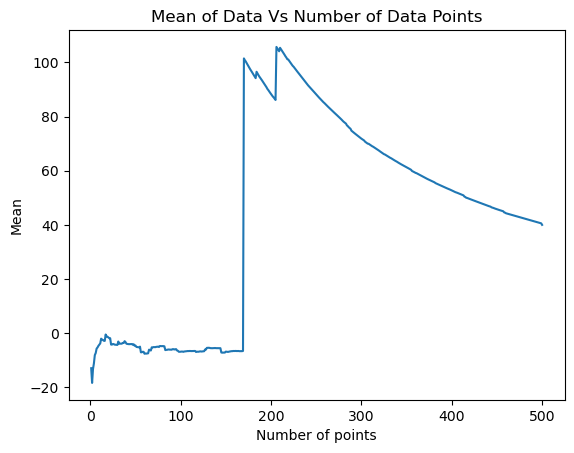

In [51]:
"""
Plot mean of data set.
"""
# YOUR CODE HERE
cumsum = np.cumsum(D)
means = cumsum/np.arange(1, N+1, 1)

num_points = np.arange(1, N+1, 1)
plt.plot(num_points, means)
plt.title("Mean of Data Vs Number of Data Points")
plt.xlabel("Number of points")
plt.ylabel("Mean");

Compare the mean with the true position of the lighthouse $\alpha_t$. Consider the fact that the data points $x_i$ in $\mathcal{D}$ follow a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution). What is the expected value of the Cauchy distribution? How many points do you expect to need to obtain a reasonable estimate of $\alpha_t$ from the mean? 

**BEGIN ANSWER**

According to the linked webpage, the expected value of the Cauchy distribution is undefined, thus no matter how many data points we generate, we are not guaranteed to obtain a reasonable estimate of $\alpha_t$ from the mean of the data points.

**END ANSWER**

### Part 3: Find the lighthouse
From the analysis in the first part we know that trying to find a maximum likelihood (or MAP) estimate in the usual way is possible (compute gradient, set equal to zero and solve), but that this does not result in a 'nice' closed-form expression for the solution, even when one of the parameters is assumed to be known. As we want to find estimates of both $\alpha$ and $\beta$ from the data, we will try a different approach instead. We start by computing the data log-likelihood, which is similar to eq. \eqref{LogLikalpha}, except that $\beta$ is now not a constant anymore:
\begin{equation*}
L(\mathcal{D} | \alpha, \beta) = \prod_{k=1}^N p(x_k | \alpha, \beta) = \prod_{k=1}^N \frac{\beta}{\pi \left[\beta^2 + (x_k - \alpha)^2 \right]} \implies \log L(\mathcal{D} | \alpha, \beta) = N \log \beta - \sum_{k=1}^N \log (\beta^2 + (x_k - \alpha)^2) + constant,
\end{equation*}
where we ignored the contribution of constant factors. We can see how this log-likelihood (as a function of $\alpha$ and $\beta$) changes as data points come in.

1. Create a function that calculates the log-likelihood at various $(\alpha, \beta)$ points after data $\mathcal{D}$ has come in.

In [52]:
def lighthouse_log_likelihood(alphas, betas, D):
    """
    Log-likelihood for a grid of alphas and betas given the data in D.
    
    Parameters
    ----------
    alphas : array
        The array containing possible positions of the lighthouse.
    betas : numeric
        The array containing possible distances from the shore.
    D : array
        The array of positions of the recorded flashes.

    Returns
    -------
    array
        Array of shape (len(alphas), len(betas)) containing the log-likelihood values.
    """
    
    # (N,) (A, B)
    # Note I had code that would brute force this solution by looping over a and b individually but I wanted to learn how to vectorise
    # So I used ChatGPT to help me understand how to do this with the following code. 

    x_minus_alpha_sq = (D[:, np.newaxis, np.newaxis] - alphas[np.newaxis, :, :])**2 # Dimension N, A, B
    log_terms = np.log(betas[np.newaxis, :, :]**2 + x_minus_alpha_sq) # Dimension N, A, B
    sum_log_terms = np.sum(log_terms, axis=0) # Dimension A, B
    print(sum_log_terms.shape)

    log_likelihoods = len(D)*np.log(betas) - sum_log_terms # Dimension A, B

    return log_likelihoods
    

In [53]:
"""
Tests for lighthouse_log_likelihood.
"""
a, b = np.mgrid[0.1:1.1:0.5, 0.1:1.1:0.5]
#print(b.shape)
#print(b)
#print(a.shape)
np.testing.assert_array_almost_equal(lighthouse_log_likelihood(a, b, np.array([np.tan(-np.pi/2),np.tan(np.pi/2)])),
                      np.array([[-153.93259496, -150.34907602], [-153.93259496, -150.34907602]]), decimal = 2)

(2, 2)


2.  Below we define the interval $[-10 \leq \alpha \leq +10] \times [0 \leq \beta \leq 5]$ with the help of `np.mgrid`. Process your data set $\mathcal{D}$ one by one and make a (surface) plot of the log-likelihood over the specified interval after one, two, three, and 20 points have arrived, respectively. 

_Hint:_ You can use, for example, the function `Axes3D.plot_surface` to make plots over the interval $[-10 \leq \alpha \leq +10] \times [0 \leq \beta \leq 5]$.

(80, 20)


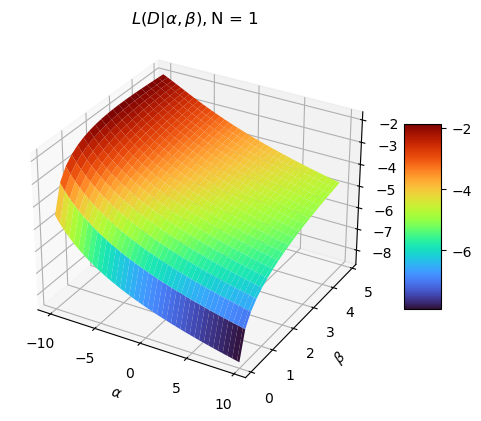

(80, 20)


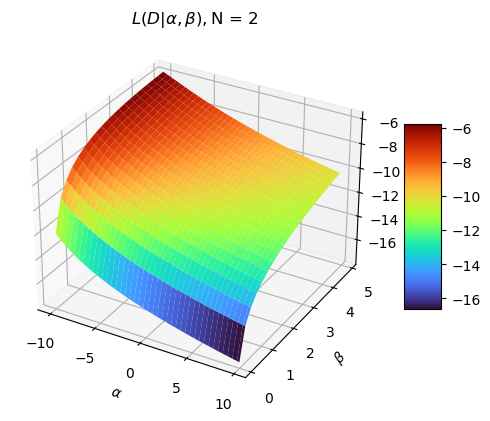

(80, 20)


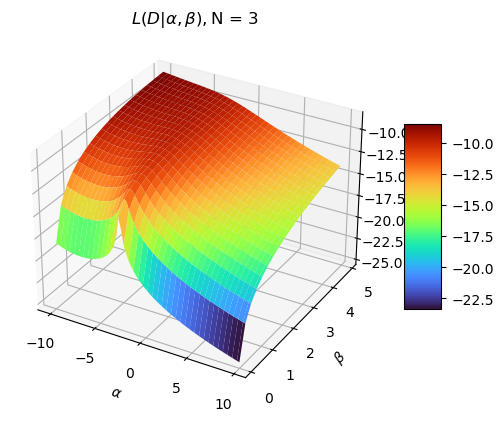

(80, 20)


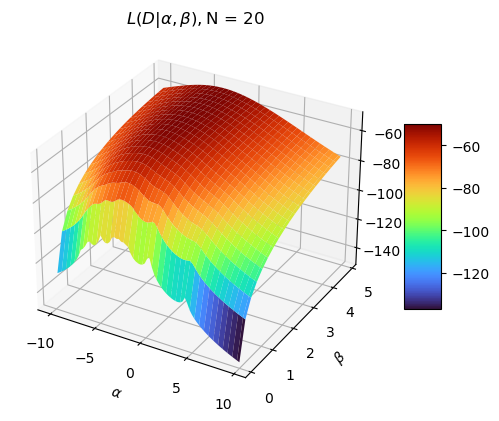

In [54]:
from matplotlib import cm

"""
Define the intervals.

Parameters
----------
A : array
    The interval [-10, 10].
B : array
    The interval [0, 5].
"""
A, B = np.mgrid[-10:10:0.25, 0.1:5:0.25]

"""
Plot 2D log-likelihood surface as a function of the number of points.
"""

def plot_log_liklihood(D, A, B):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    LLL = lighthouse_log_likelihood(A, B, D)
    surface = ax.plot_surface(A, B, LLL, cmap=cm.turbo, label=f"N={len(D)}")
    fig.colorbar(surface, shrink=0.5, aspect=5, )
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.title(r'$L(D|\alpha, \beta), $' + f"N = {len(D)}")
    plt.show()


data_index = [1, 2, 3, 20]

for index in data_index:
    
    plot_log_liklihood(D[:index], A, B)



What happens to the (log-)likelihood surface as each batch of data points arrives?

**START ANSWER**

From the first plot where we only have a single datapoint, the most likely value for $\alpha$ and $\beta$ appear to be around $\alpha=-10, \beta=5$, but as we collect more and more samples, the plot changes to place the most likely value for the two parameters at the MAP/MLE values, specfifically $\alpha \approx -5, \beta \approx 3$, which is expected since in the limit of data, we expect the likelihood plot to assign the most probable values to the true parameter values.

**END ANSWER**

We can make a reasonable (visual) estimate of the most probable position of the lighthouse from the graph, after a few data points have been observed. However, as we are working on a computer, we can let it do the dirty work for us.

3. Create a function that uses `scipy.optimize.fmin` to compute the values of $\alpha$ and $\beta$ that maximize the likelihood for a data set of $k$ points, and plot these as a function of the number of points. Build a wrapper around `lighthouse_log_likelihood` (taking $\mathbf{x} = [\alpha, \beta]$ as input) to pass on to the minimization function and use $[0,1]$ as the initial starting value for `scipy.optimize.fmin`.

In [55]:
#x0 = np.array([0.0, 1.0])

def wrapper(x0, D):
    a, b = x0
    # Put in correct format
    a = np.array([[a]])
    b = np.array([[b]])
    value = lighthouse_log_likelihood(a, b, D)
    return -value.item()

def ml_estimate(D):
    """
    ML estimate of the lighthouse position as a function of the number of points.
    
    Parameters
    ----------
    D : array
        The array of positions of the recorded flashes.

    Returns
    -------
    array
        The result of fmin for each flash point.
    """
    # YOUR CODE HERE

    return scipy.optimize.fmin(wrapper, (0.0, 1.0), args=(D, ))

In [56]:
"""
Tests for ml_estimate.
"""

'\nTests for ml_estimate.\n'

Now plot the computed values for $\alpha$ and $\beta$ as a function of the number of points, so that you can compare your final estimate with the true values $(\alpha_t, \beta_t)$. 

NB: This is not a form of sequential learning, since each time the entire data set is used to find the maximum likelihood.

In [ ]:
"""
Plot position estimates.
"""
estimates = np.zeros((len(D), 2))
for i in range(1, len(D)):
    result = ml_estimate(D[:i]);
    estimates[i] = result;



[-4.90641386]
[2.99811562]


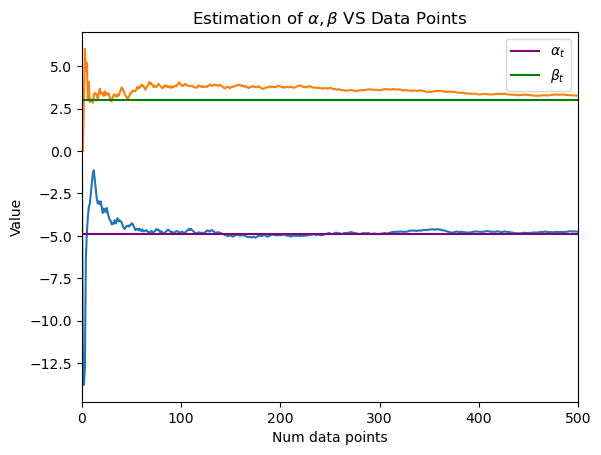

In [58]:
num_points = np.arange(0, len(D), 1)
plt.plot(num_points, estimates)
plt.axhline(a_t, label = r"$\alpha_t$", color = "purple")
plt.axhline(b_t, label = r"$\beta_t$", color="green")
plt.legend()
plt.title(r"Estimation of $\alpha, \beta$ VS Data Points")
plt.xlabel("Num data points")
plt.ylabel("Value")
plt.xlim(0,500)
print(a_t)
print(b_t)


As expected the estimated values for $\alpha, \beta$ gradually approximate the true values in the limit of data points collected.